In [129]:
#Here we will implement previous code with the DLC package. This requires H5 files...

In [130]:
#Imports

import pandas as pd

import os
import re
import numpy as np
from sympy  import *
import matplotlib.pyplot as plt
import dlc2kinematics
from dlc2kinematics import Visualizer2D

#classes imports
from preprocessing.classes import FilterandThresholds
#Initialize classes
splitter = FilterandThresholds('tester')


In [131]:
#Lets see what the dlc2kinematics has to offer

#In this we want to import our files, load the data and extract kinematics
#path = r''
path = r'/Users/carlospineda/Desktop/TEMP Reaching Results for Code Dev/camera3/'
configCam3 = r'/Users/carlospineda/Desktop/TEMP Reaching Results for Code Dev/config/config.yaml'
files = [file for file in os.listdir(path)]
scale = 2.9

#Allocate datframes
velocity = []
for file in files:

    if 'left' in file:
        data_singlereach, bodyparts, scorer = dlc2kinematics.load_data(path + file, smooth = True, filter_window=3)

        #we want to split the data into the two basic reaching components: extention and retraction
        data_extention = data_singlereach.iloc[0: np.argmin(data_singlereach[scorer]['WristL']['x']), :]
        data_retraction = data_singlereach.iloc[np.argmin(data_singlereach[scorer]['WristL']['x']):-1, :]
        #print(data_extention)

        #SCALE THE DATA SO THAT THE COORDS ARE IN MM -
        data_extention_scaled = data_extention.apply(lambda x: x/scale if x.name not in ['likelihood'] else x)
        #data_extention_rescaled = data_extention_scaled.apply(lambda: x - data_extention)

        #RESCALE THE REACHES SO YOU CAN PLOT THEM TOGETHER
        #Try1: substract all numbers by however much you had to substract the first to get it to 0. The resulting dataset should be kept separate from the original.
        #data_extention_rescaled =

        #print(len(data_extention))
        #velocity
        df_vel = dlc2kinematics.compute_velocity(data_extention_scaled,bodyparts=['WristL'], filter_window = 13, order=1)
        #df_speed = dlc2kinematics.compute_speed(data_singlereach,bodyparts=['all'], filter_window=3, order=1)


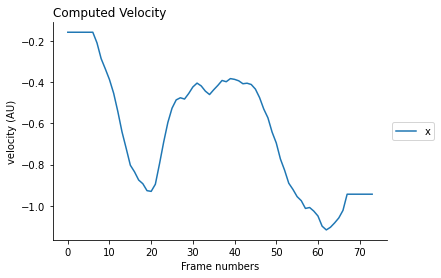

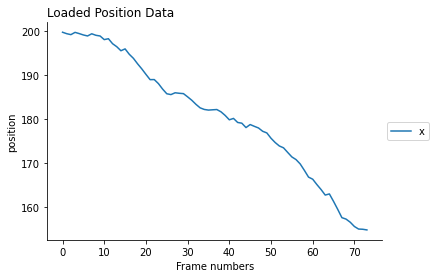

In [132]:
#*TEST PLOTTING
import matplotlib.pyplot as plt
dlc2kinematics.plot_velocity(data_extention_scaled[scorer]['WristL']['x'], df_vel[scorer]['WristL']['x'])#, start=42150,end=42450) #42150:42450